# Problem 1

We've been given application logs simulated from an ideal system consisting of one server which processes requests sequentially on a single thread. Requests are sent to the server and are processed in first-in, first-out order. If a request arrives while the server is busy, it waits in a queue until the server frees up. The queue size is infinite. In this simple setup, the response time for a request is the time spent in queue plus the server time:

$W = d + s$

The delay $d$ depends on the arrival and number of prior requests, but the server time $s$ is assumed to be independent and identically-distributed across requests.

We've been given data for two scenarios, each consisting of log data over a two-week period at a frequency of one second. There are no logs for seconds in which there were no requests. It is assumed that the data has already been downloaded and resides in the same directory as the notebook. We start by loading up the data.

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load data
logs = {}

scenarios = ['scenario1', 'scenario2']
for scenario in scenarios:
    logs[scenario] = pd.read_csv(
        scenario + '.txt', sep='\t', names=['time', 'num_requests', 'mean_response_time'])

In [3]:
# inspect the data
for scenario in scenarios:
    print(
        scenario, 'has', len(logs[scenario]), 'times and looks like\n', logs[scenario].head())

scenario1 has 1188061 times and looks like
     time  num_requests  mean_response_time
0  21601             2               0.052
1  21602             1               0.034
2  21603             5               0.077
3  21604             4               0.064
4  21605             1               0.138
scenario2 has 1187040 times and looks like
     time  num_requests  mean_response_time
0  21601             5               0.069
1  21602             3               0.076
2  21606             3               0.071
3  21608             2               0.097
4  21609             1               0.045


The first column is the time in seconds since $t=0$. The second column is the number of requests processed since last log. The third column is the mean response time for those requests. The second week starts at $t=626400$ s in the files, which corresponds to 6 AM on the 8th day. The first value $t=21601$ s corresponds to 6 AM on the first day.

We'd like to answer the following questions for both scenarios.

## Question 1

$Q$: How much has the mean response time (specifically, the mean of the response
times for each individual request) changed from week 1 to week 2?

$A$: To obtain the mean response time per request, we can't simply average the mean response times in the files directly, because different numbers of requests are processed at each log. Therefore we need to do a weighted average that takes this into account. This can be done simply by multiplying the number of requests by the mean response time to get total response time for those requests, then dividing by the total number of requests across all times. This must be done for both scenarios and both weeks.

First define a utility function to get the mean.

In [4]:
def get_mean_response_time(df):
    """Get mean response time.
    
       Dataframe must contain num_requests and mean_response_time columns.
    """
    return (df['num_requests'] * df['mean_response_time']).sum() / df['num_requests'].sum()

In [5]:
time_start_week_two = 626400

logs_by_week = {
    'week1': {},
    'week2': {}}

for scenario in scenarios:
    print(scenario, '\n=========')
    
    # week one
    logs_by_week['week1'][scenario] = logs[scenario][
        logs[scenario]['time'] < time_start_week_two]
    print('Mean response time for week 1 =',
        get_mean_response_time(logs_by_week['week1'][scenario]))
    
    # week two
    logs_by_week['week2'][scenario] = logs[scenario][
        logs[scenario]['time'] >= time_start_week_two]
    print('Mean response time for week 2 =',
        get_mean_response_time(logs_by_week['week2'][scenario]))
    
    print('')

scenario1 
Mean response time for week 1 = 0.18509407449429063
Mean response time for week 2 = 0.4692574097535095

scenario2 
Mean response time for week 1 = 0.18323224250568954
Mean response time for week 2 = 0.27242308498379386



The mean response time goes up around 150% for scenario one, while for scenario two, it only goes up by 50%. As their week one mean response times are nearly identical, there's probably something different that's happening in scenario one compared to scenario that's causing the increased response times.

## Question 2

$Q$: Create a plot illustrating the probability distribution of the amount of
server time it takes to process a request (excluding the time the request
spends waiting in the queue). How would you describe the distribution?

$A$: Based on the equation above, we'd like to get a distribution of $s$, given the sum of $W$ over different batches of processed requests. However, we don't know what the delays are coming from requests being put into the queue. For example, for a given log interval, if requests come in all at once, some fraction of the total time is due to being in queue, but if each request comes in after the last was processed, there's no delay in processing (assuming the queue was empty at the start of the interval). This makes finding a distribution for $s$ difficult.

However, we can approximate the distribution for $s$ by focusing on the case where the number of requests processed since the last log is one. In this case, we know for sure the total processing time for that request. We still don't know how many requests are queued up at the start of the interval, but it's likely there are none, because if there were, that request as well as the other probably would've been processed. So if the queue is empty, then the processing time is the server time.

Below are the empirical probability distributions of the server time for scenario one, both overall and broken down by week.

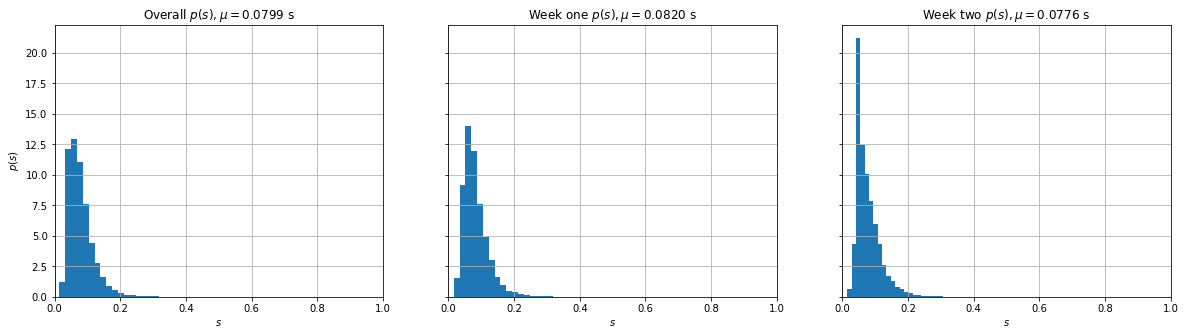

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

server_times_overall = logs['scenario1'][
    logs['scenario1']['num_requests'] == 1]['mean_response_time']
server_times_week1 = logs_by_week['week1']['scenario1'][
    logs_by_week['week1']['scenario1']['num_requests'] == 1]['mean_response_time']
server_times_week2 = logs_by_week['week2']['scenario1'][
        logs_by_week['week2']['scenario1']['num_requests'] == 1]['mean_response_time']

# overall
ax[0].hist(server_times_overall, bins=50, density=True)
ax[0].grid(True)
ax[0].set_title(
    'Overall $p(s), \mu = {:.4f}$ s'.format(server_times_overall.mean()))
ax[0].set_xlabel('$s$')
ax[0].set_ylabel('$p(s)$')

# week one
ax[1].hist(server_times_week1, bins=50, density=True)
ax[1].grid(True)
ax[1].set_title(
    'Week one $p(s), \mu = {:.4f}$ s'.format(server_times_week1.mean()))
ax[1].set_xlabel('$s$')

# week two
ax[2].hist(server_times_week2, bins=50, density=True)
ax[2].grid(True)
ax[2].set_title('Week two $p(s), \mu = {:.4f}$ s'.format(server_times_week2.mean()))
ax[2].set_xlabel('$s$')

plt.xlim([0, 1]);

As expected, the distribution doesn't change much week to week, because the server time is dependent on the application and though it can vary with the size of the request, it doesn't change on average with the number of requests. These distributions look like the exponential distribution. In simple queue models, the number of arrivals in a given period is Poisson (i.e., interarrival times are independently exponentially distributed) and the service times are exponentially distributed. Because the plots above also capture some amount of queue time, the server time in reality will be slightly less on average, and the distributions would resemble the exponential distribution even more.

These are the same plots for scenario two.

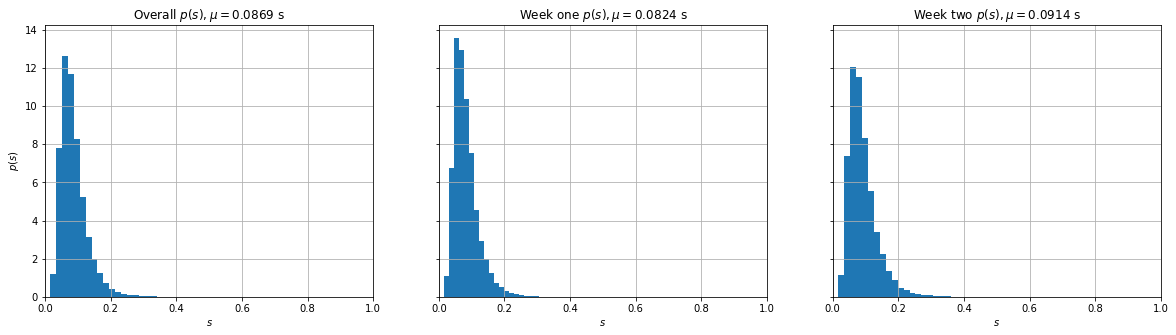

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

server_times_overall = logs['scenario2'][
    logs['scenario2']['num_requests'] == 1]['mean_response_time']
server_times_week1 = logs_by_week['week1']['scenario2'][
    logs_by_week['week1']['scenario2']['num_requests'] == 1]['mean_response_time']
server_times_week2 = logs_by_week['week2']['scenario2'][
        logs_by_week['week2']['scenario2']['num_requests'] == 1]['mean_response_time']

# overall
ax[0].hist(server_times_overall, bins=50, density=True)
ax[0].grid(True)
ax[0].set_title(
    'Overall $p(s), \mu = {:.4f}$ s'.format(server_times_overall.mean()))
ax[0].set_xlabel('$s$')
ax[0].set_ylabel('$p(s)$')

# week one
ax[1].hist(server_times_week1, bins=50, density=True)
ax[1].grid(True)
ax[1].set_title(
    'Week one $p(s), \mu = {:.4f}$ s'.format(server_times_week1.mean()))
ax[1].set_xlabel('$s$')

# week two
ax[2].hist(server_times_week2, bins=50, density=True)
ax[2].grid(True)
ax[2].set_title('Week two $p(s), \mu = {:.4f}$ s'.format(server_times_week2.mean()))
ax[2].set_xlabel('$s$')

plt.xlim([0, 1]);

Similar results hold. Notice that these plots look similar to the ones above and have similar means. This is what you'd expect if server time doesn't depend on average on time.

## Question 3

$Q$: Propose a potential cause for the change in response times. Give both a
qualitative answer as if you were explaining it to a client and a quantitative
answer as if you were explaining it to a statistician. Create 1 or 2 plots to
support and illustrate your argument.

$A$: For scenario one, the mean server time between week one and week two is about the same, but the mean response time went up by 150%. Note that the mean response time is the sum of the mean queue and mean server times:

$\bar{W} = \bar{d} + \bar{s}$

It follows that the mean queue time for week 1 is $\bar{d}_1 = \bar{W}_1 - \bar{s}_1 = 0.185 - 0.082 = 0.103$, and the mean queue time for week 2 is $0.469-0.078=0.391$. So the queue time increased by 280% from week to week.

To a client, you'd say that many more people hit up the service on the second week, increasing wait times. The reasons for the increased traffic can then be assessed.

To support this analysis, you can produce plots of the number of incoming requests over time. However, we don't know the number of incoming requests at a given time, but instead the number of requests processed. This can be used as a proxy. Below is a plot of the number of cumulative processed requests for the two weeks.

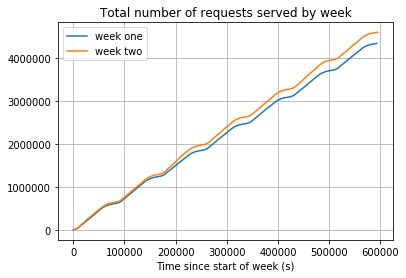

In [42]:
import numpy as np

cum_requests = np.cumsum(
    logs_by_week['week1']['scenario1']['num_requests'])
plt.step(
    range(1, len(cum_requests) + 1), cum_requests, label='week one')

cum_requests = np.cumsum(
    logs_by_week['week2']['scenario1']['num_requests'])
plt.step(
    range(1, len(cum_requests) + 1), cum_requests, label='week two')

plt.grid(True)
plt.xlabel('Time since start of week (s)')
plt.legend(loc='best')
plt.title('Total number of requests served by week');

As you can see, the number of processed requests for week two starts to increase noticeably from that in week one at two days into the week ($t=200000$ s).

You can also plot histograms of the number of requests from week to week.

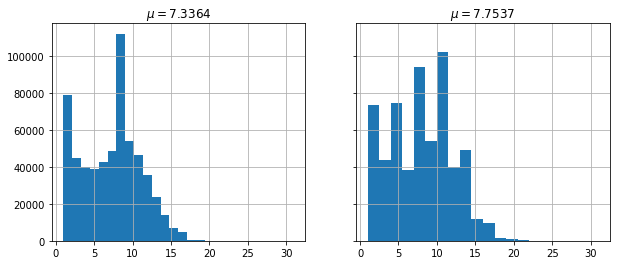

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax[0].hist(
    logs_by_week['week1']['scenario1']['num_requests'], bins=20)
ax[0].grid(True)
ax[0].set_title('$\mu = {:.4f}$'.format(
    logs_by_week['week1']['scenario1']['num_requests'].mean()))

ax[1].hist(
    logs_by_week['week2']['scenario1']['num_requests'], bins=20)
ax[1].grid(True)
ax[1].set_title('$\mu = {:.4f}$'.format(
    logs_by_week['week2']['scenario1']['num_requests'].mean()));

As expected, the mean goes up from week to week.

The same analysis can be done for scenario two. In that case, the average queue time for week one is $0.183-0.0824=0.100$, and for week two is $0.272-0.0914=0.181$, which represents a much smaller change. It's hard to say if this change is large or not, since we don't know the standard deviation of response and server times, but we can reproduce the same plots above to see if the load has increased significantly.

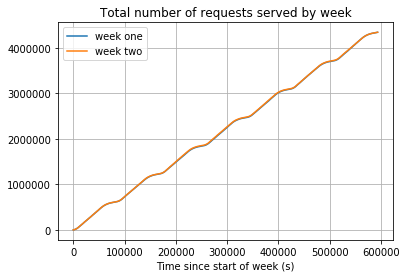

In [58]:
cum_requests = np.cumsum(
    logs_by_week['week1']['scenario2']['num_requests'])
plt.step(
    range(1, len(cum_requests) + 1), cum_requests, label='week one')

cum_requests = np.cumsum(
    logs_by_week['week2']['scenario2']['num_requests'])
plt.step(
    range(1, len(cum_requests) + 1), cum_requests, label='week two')

plt.grid(True)
plt.xlabel('Time since start of week (s)')
plt.legend(loc='best')
plt.title('Total number of requests served by week');

The number of processed requests is very similar, as the previous means would suggest.

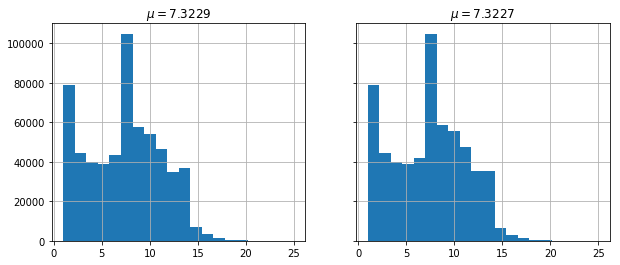

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax[0].hist(
    logs_by_week['week1']['scenario2']['num_requests'], bins=20)
ax[0].grid(True)
ax[0].set_title('$\mu = {:.4f}$'.format(
    logs_by_week['week1']['scenario2']['num_requests'].mean()))

ax[1].hist(
    logs_by_week['week2']['scenario2']['num_requests'], bins=20)
ax[1].grid(True)
ax[1].set_title('$\mu = {:.4f}$'.format(
    logs_by_week['week2']['scenario2']['num_requests'].mean()));

The histograms of processed requests and the overall mean don't change significantly either. So we come to the conclusion that the increased load and mean response times are really only present for scenario one.